Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,image_size=(img_height,img_width))

Found 6739 files belonging to 9 classes.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,seed=123,image_size=(img_height,img_width),batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [8]:
labels = []
for x, y in train_ds:
  # Not one hot encoded
  labels.append(y.numpy())

  # If one hot encoded, then apply argmax
  # labels.append(np.argmax(y, axis = -1))
labels = np.concatenate(labels, axis = 0) # Assuming dataset was batched.

In [9]:
tf.math.bincount(labels,axis=-1)

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([614, 876, 595, 938, 857, 962, 577, 681, 639], dtype=int32)>

In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

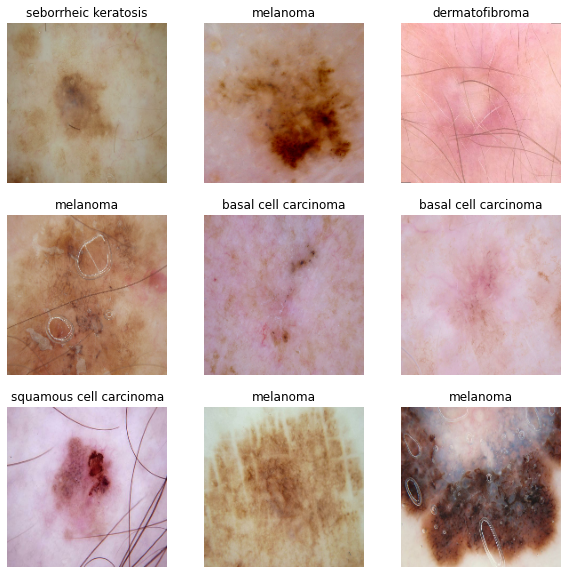

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
normalization_layer = tf.keras.layers.Rescaling(1./255)


## Lets see if normalized works as a sample, but we will use rescaling as layer in model 

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00784218 0.7344771


In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 1st layer is rescaling followed by convolutions and pooling layers 

In [16]:
## Lets create the model.
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.build(input_shape=[32,180,180,3])

In [19]:
# View the summary of all layers
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 178, 178, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 89, 89, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 87, 87, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 43, 43, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 41, 41, 32)          9

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
211/211 [==============================] - 163s 772ms/step - loss: 1.8437 - accuracy: 0.2905 - val_loss: 1.9046 - val_accuracy: 0.3136
Epoch 2/20
211/211 [==============================] - 155s 734ms/step - loss: 1.4578 - accuracy: 0.4559 - val_loss: 2.0962 - val_accuracy: 0.3983
Epoch 3/20
211/211 [==============================] - 254s 1s/step - loss: 1.2998 - accuracy: 0.5007 - val_loss: 2.4262 - val_accuracy: 0.4492
Epoch 4/20
211/211 [==============================] - 277s 1s/step - loss: 1.1878 - accuracy: 0.5487 - val_loss: 2.4153 - val_accuracy: 0.3644
Epoch 5/20
211/211 [==============================] - 286s 1s/step - loss: 1.0519 - accuracy: 0.6120 - val_loss: 2.6111 - val_accuracy: 0.3814
Epoch 6/20
211/211 [==============================] - 300s 1s/step - loss: 0.9092 - accuracy: 0.6635 - val_loss: 3.2471 - val_accuracy: 0.4068
Epoch 7/20
211/211 [==============================] - 310s 1s/step - loss: 0.8082 - accuracy: 0.6977 - val_loss: 3.1754 - val_accuracy: 

### Visualizing training results

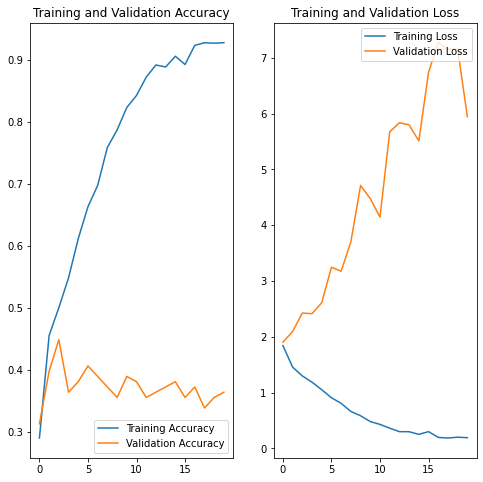

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### First level findings after the model fit, see if there is an evidence of model overfit or underfit

### Result 1: Clearly the model is overfitting as, we see training loss and accuracy has being increasing with epocs of trainings , reaching a accuracy of around 88% but validation accuracy is up and down and never crosses 38% . This means model does not perform well on unseen validation data and we need to handle same.

In [22]:
#  Now  we have analysed the model fit history for presence of overfit, lets start with a data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


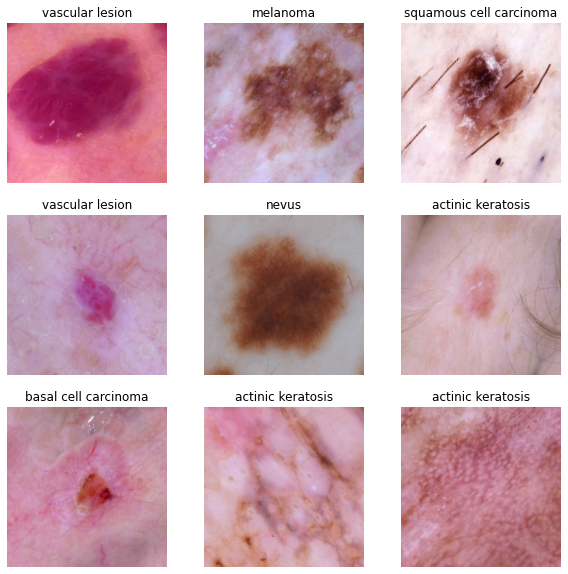

In [23]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(images[i])
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Lets add this data Augmentation layer first and check the results.
### Create the model, compile and train the model


In [24]:
## We can also use Dropout layer if there is an evidence of overfitting in your findingsrnum_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])




### Compiling the model

In [25]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.build(input_shape=[32,180,180,3])

In [27]:
# View the summary of all layers
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 random_flip_1 (RandomFlip)  (32, 180, 180, 3)         0         
                                                                 
 random_rotation_1 (RandomRo  (32, 180, 180, 3)        0         
 tation)                                                         
                                                                 
 conv2d_3 (Conv2D)           (32, 178, 178, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 89, 89, 32)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (32, 87, 87, 32)         

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
211/211 [==============================] - 159s 740ms/step - loss: 1.8111 - accuracy: 0.3033 - val_loss: 1.9452 - val_accuracy: 0.2966
Epoch 2/20
211/211 [==============================] - 153s 726ms/step - loss: 1.5018 - accuracy: 0.4306 - val_loss: 2.2820 - val_accuracy: 0.3644
Epoch 3/20
211/211 [==============================] - 203s 962ms/step - loss: 1.4182 - accuracy: 0.4594 - val_loss: 2.0746 - val_accuracy: 0.3559
Epoch 4/20
211/211 [==============================] - 153s 726ms/step - loss: 1.3354 - accuracy: 0.4878 - val_loss: 2.2474 - val_accuracy: 0.3729
Epoch 5/20
211/211 [==============================] - 158s 750ms/step - loss: 1.2947 - accuracy: 0.4995 - val_loss: 2.1916 - val_accuracy: 0.4153
Epoch 6/20
211/211 [==============================] - 209s 992ms/step - loss: 1.2661 - accuracy: 0.5211 - val_loss: 2.5159 - val_accuracy: 0.4153
Epoch 7/20
211/211 [==============================] - 298s 1s/step - loss: 1.2319 - accuracy: 0.5364 - val_loss: 2.3074 - va

### Visualizing the results

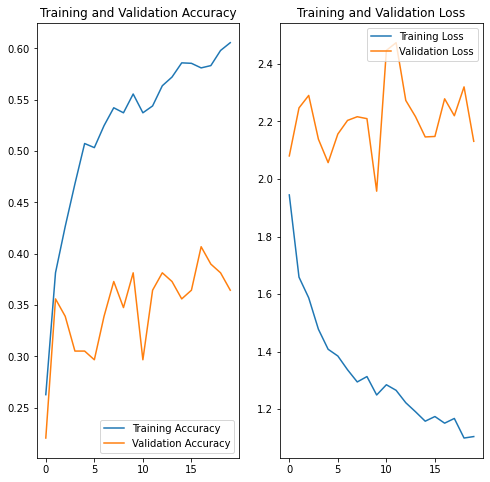

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit after Data augmentation of flip and rotation,  , results are poorer than before, there is an evidence of model underfit. there is no improvement

## Lets try with a different agumentation and see and also do drop outs as regularization.

In [39]:
#  Now  we have analysed the model fit history for presence of overfit, lets start with a data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
  layers.RandomContrast(factor=0.4),
   layers.RandomZoom(.5,.2)
])


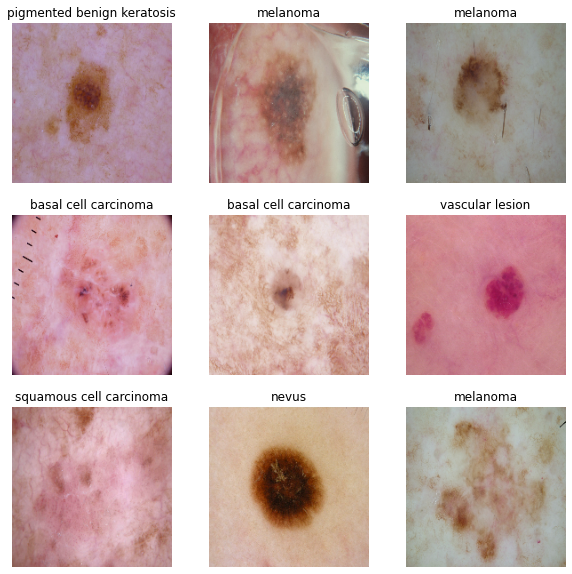

In [40]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(images[i])
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [45]:
## We can also use Dropout layer if there is an evidence of overfitting in your findings
rnum_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomContrast(factor=0.3),
  tf.keras.layers.RandomZoom(.5,.3),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])




In [46]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model.build(input_shape=[32,180,180,3])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 random_contrast_3 (RandomCo  (32, 180, 180, 3)        0         
 ntrast)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (32, 180, 180, 3)         0         
                                                                 
 random_flip_2 (RandomFlip)  (32, 180, 180, 3)         0         
                                                                 
 random_rotation_2 (RandomRo  (32, 180, 180, 3)        0         
 tation)                                                         
                                                                 
 conv2d_15 (Conv2D)          (32, 178, 178, 32)       

In [48]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 55s 772ms/step - loss: 1.9003 - accuracy: 0.3037 - val_loss: 2.1436 - val_accuracy: 0.2542
Epoch 2/20
70/70 [==============================] - 59s 845ms/step - loss: 1.6417 - accuracy: 0.4015 - val_loss: 2.2736 - val_accuracy: 0.2627
Epoch 3/20
70/70 [==============================] - 58s 830ms/step - loss: 1.5393 - accuracy: 0.4551 - val_loss: 2.1977 - val_accuracy: 0.2542
Epoch 4/20
70/70 [==============================] - 60s 853ms/step - loss: 1.5431 - accuracy: 0.4609 - val_loss: 2.0496 - val_accuracy: 0.3220
Epoch 5/20
70/70 [==============================] - 57s 817ms/step - loss: 1.4575 - accuracy: 0.4783 - val_loss: 2.0650 - val_accuracy: 0.3136
Epoch 6/20
70/70 [==============================] - 55s 781ms/step - loss: 1.4175 - accuracy: 0.4949 - val_loss: 2.0198 - val_accuracy: 0.3729
Epoch 7/20
70/70 [==============================] - 54s 771ms/step - loss: 1.3944 - accuracy: 0.4953 - val_loss: 1.9566 - val_accuracy: 0.3475

### Slight improvement in validation accuracy , but training accuracy has gone down !! data augmentation is not helping

In [29]:
## We can also use Dropout layer if there is an evidence of overfitting in your findings
rnum_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes)
])




In [30]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.build(input_shape=[32,180,180,3])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 178, 178, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 89, 89, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 87, 87, 32)          9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 43, 43, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (32, 43, 43, 32)         

In [32]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
211/211 [==============================] - 169s 794ms/step - loss: 1.8788 - accuracy: 0.2765 - val_loss: 2.0634 - val_accuracy: 0.3220
Epoch 2/20
211/211 [==============================] - 170s 807ms/step - loss: 1.5468 - accuracy: 0.4165 - val_loss: 2.0238 - val_accuracy: 0.3729
Epoch 3/20
211/211 [==============================] - 154s 732ms/step - loss: 1.3611 - accuracy: 0.4809 - val_loss: 2.0548 - val_accuracy: 0.3475
Epoch 4/20
211/211 [==============================] - 149s 706ms/step - loss: 1.2268 - accuracy: 0.5345 - val_loss: 2.1038 - val_accuracy: 0.3559
Epoch 5/20
211/211 [==============================] - 160s 761ms/step - loss: 1.0951 - accuracy: 0.5814 - val_loss: 2.3976 - val_accuracy: 0.3729
Epoch 6/20
211/211 [==============================] - 145s 685ms/step - loss: 0.9752 - accuracy: 0.6289 - val_loss: 2.5477 - val_accuracy: 0.3390
Epoch 7/20
211/211 [==============================] - 144s 681ms/step - loss: 0.8636 - accuracy: 0.6686 - val_loss: 2.2651 -

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
labels = []
for x, y in train_ds:
  # Not one hot encoded
  labels.append(y.numpy())

  # If one hot encoded, then apply argmax
  # labels.append(np.argmax(y, axis = -1))
labels = np.concatenate(labels, axis = 0) # Assuming dataset was batched.

In [34]:
tf.math.bincount(labels)

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([614, 876, 595, 938, 857, 962, 577, 681, 639], dtype=int32)>

In [38]:
print (class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## there is clearly imbalance in the dataset with the amount of file images per class as you see above.

#### - please see findings here: 
#### - Which class has the least number of samples?
#### Answer : dermatofibroma

#### - Which classes dominate the data in terms proportionate number of samples?
#### Answer - Melanoma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
path_to_training_dataset=pathlib.Path("./Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + '/'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF4998565B0>:   0%|          | 1/500 [00:00<01:29,  5.59 Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF4999B3790>: 100%|██████████| 500/500 [00:11<00:00, 43.44 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF49BD60550>:   0%|          | 1/500 [00:00<00:53,  9.39 Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF494441880>: 100%|██████████| 500/500 [00:13<00:00, 38.23 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF4999B3310>:   0%|          | 1/500 [00:00<01:37,  5.11 Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF499935A30>: 100%|██████████| 500/500 [00:12<00:00, 39.24 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF4937A7D30>: 100%|██████████| 500/500 [00:57<00:00,  8.67 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF4937A27C0>: 100%|██████████| 500/500 [00:51<00:00,  9.76 Samples/s]  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF493785B50>: 100%|██████████| 500/500 [00:11<00:00, 44.14 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FF4937D6D60>: 100%|██████████| 500/500 [00:26<00:00, 19.17 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF5F7FB4790>:   0%|          | 1/500 [00:00<00:31, 15.98 Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF4999B33D0>: 100%|██████████| 500/500 [00:11<00:00, 43.26 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF4944415E0>:   1%|          | 3/500 [00:00<01:12,  6.85 Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF49BD608B0>: 100%|██████████| 500/500 [00:11<00:00, 44.10 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [42]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[0]

'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009918.jpg_9a2c85e1-0c0d-423c-b09e-16dcf328a454.jpg'

In [44]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[0]

'melanoma'

In [45]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [47]:
df2['Label'].value_counts()

pigmented benign keratosis    500
squamous cell carcinoma       500
seborrheic keratosis          500
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [48]:
batch_size = 32
img_height = 180
img_width = 180

#### Let's create a new directory with augmented images and use same to load the Tensor flow batch data set.

In [52]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list
        
directory_names=unique(lesion_list_new)
print (directory_names)

['melanoma', 'pigmented benign keratosis', 'nevus', 'basal cell carcinoma', 'actinic keratosis', 'squamous cell carcinoma', 'vascular lesion', 'seborrheic keratosis', 'dermatofibroma']


In [50]:
new_dir="Skin cancer ISIC The International Skin Imaging Collaboration/Train-new/"
os.makedirs(new_dir)

In [53]:
### copy the augmented images from original output directory to new directories.
import shutil
for i in directory_names:
    src = str(path_to_training_dataset) + '/' + i + "/" + "output"
    dst = new_dir  + i 
    shutil.copytree(src, dst, symlinks=False, ignore=None, ignore_dangling_symlinks=False, dirs_exist_ok=False)

#### **Todo:** Create a training dataset

In [54]:
data_dir_train=pathlib.Path(new_dir)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [55]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [56]:
## Lets create the model.
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [29]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.build(input_shape=[32,180,180,3])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 178, 178, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 89, 89, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 87, 87, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 43, 43, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 41, 41, 32)          9

#### **Todo:**  Train your model

In [31]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
113/113 [==============================] - 100s 865ms/step - loss: 1.8566 - accuracy: 0.2742 - val_loss: 1.4723 - val_accuracy: 0.3989
Epoch 2/50
113/113 [==============================] - 96s 843ms/step - loss: 1.5014 - accuracy: 0.4072 - val_loss: 1.3818 - val_accuracy: 0.4500
Epoch 3/50
113/113 [==============================] - 94s 822ms/step - loss: 1.3790 - accuracy: 0.4811 - val_loss: 1.2848 - val_accuracy: 0.5256
Epoch 4/50
113/113 [==============================] - 94s 822ms/step - loss: 1.2328 - accuracy: 0.5394 - val_loss: 1.2005 - val_accuracy: 0.5422
Epoch 5/50
113/113 [==============================] - 94s 822ms/step - loss: 1.1438 - accuracy: 0.5692 - val_loss: 1.1968 - val_accuracy: 0.5578
Epoch 6/50
113/113 [==============================] - 95s 831ms/step - loss: 1.0193 - accuracy: 0.6300 - val_loss: 0.9799 - val_accuracy: 0.6544
Epoch 7/50
113/113 [==============================] - 95s 833ms/step - loss: 0.8692 - accuracy: 0.6881 - val_loss: 1.0313 - val_a

#### **Todo:**  Visualize the model results

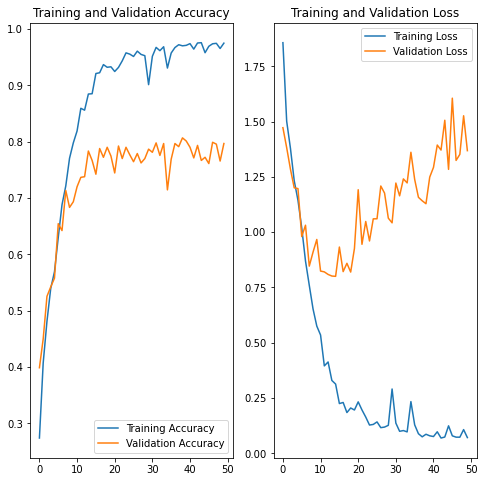

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### When we analyse the results after class rebalancing , we see clearly there is improvement in Training accuracy and also validation accuracy is around 80% .